<a href="https://colab.research.google.com/github/Naif-Albader/Classification_Project/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
import requests
from bs4 import BeautifulSoup
import json
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
import time
import timeit
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import re,string,unicodedata

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras



from wordcloud import WordCloud,STOPWORDS
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense
import matplotlib.pyplot as plt





KeyboardInterrupt: ignored

# Data Gathering & Scarping

In [ ]:
def clean_num(s):
    return "".join(re.findall('\d*\.?\d+',s))

def get_data(block, tag, class_text):
    try:
        return block.find(tag, class_ = class_text).text
    except AttributeError:
        return ""
    return

In [ ]:
url = "https://www.imdb.com/title/tt0468569/reviews?ref_=tt_ql_3"
url2 = "https://www.imdb.com/title/tt6027920/reviews?ref_=tt_ql_3"
response = requests.get(url)
response.status_code
driver = webdriver.Chrome('/Applications/chromedriver')
driver.get(url2)
for i in range(4000): #scroll 3000 times
    driver.find_element_by_class_name('ipl-load-more__button').click()
    time.sleep(3)


NameError: ignored

In [ ]:
page = driver.page_source
soup = BeautifulSoup(page, 'lxml')

In [ ]:
reviews_list = []
for i in (soup.find_all("div", class_ = "lister-item-content")):
    reviews =  str.strip(get_data(i, "div", "text show-more__control"))
    rating =  str.strip(get_data(i, "span", "rating-other-user-rating"))
    rating = rating.split(sep='/')[0]
    date = str.strip(get_data(i, "span", "review-date"))
    
    x =get_data(i, "div", "actions text-muted")
    x = x.replace(',',"")
    like = [int(s) for s in x.split() if s.isdigit()]
    
    if(like):
         like = [int(s) for s in x.split() if s.isdigit()][0]
            
    dislike = [int(s) for s in x.split() if s.isdigit()]
    
    
    if(dislike):
         dislike = [int(s) for s in x.split() if s.isdigit()][1]
        
    
    
    

    
    headers = ['Review_text', 'Rating','date','like','dislike']
    rev_dict = dict(zip(headers, [ reviews,
                                    rating,date,like,dislike]))
    reviews_list.append(rev_dict)

df = pd.DataFrame(reviews_list).replace("",np.nan)  #convert list of dict to df
df

In [ ]:
df = df[~df.Rating.isna()]

In [ ]:
df['Rating'] = df.Rating.astype(int)

In [ ]:
clean_df = df[~df.Review_text.isna()]

In [ ]:
# clean_df.to_pickle("clean_df_1st.pkl")
clean_df.to_pickle("clean_df_2st.pkl")

In [ ]:
df = pd.read_pickle("clean_df_1st.pkl")

# Cleaning & feature engineering & EDA 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# put your you path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pickles/1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pickles/2.csv')
dfs = [df,df2]

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.isnull().sum()

Unnamed: 0     0
Review_text    0
Rating         0
date           0
like           0
dislike        0
dtype: int64

In [ ]:
df

,Unnamed: 0,Review_text,Rating,date,like,dislike
0,0,Best movie ever. Heath ledger's work is phenom...,10,12 January 2021,153,165
1,1,Totally one of the greatest movie titles ever ...,10,9 January 2021,132,145
2,2,It is just what you want for the best movie. G...,10,7 October 2019,235,274
3,3,"Confidently directed, dark, brooding, and pack...",10,12 February 2020,465,557
4,4,I got to see The Dark Knight on Wednesday nigh...,10,20 July 2008,965,1171
...,...,...,...,...,...,...
7104,7533,:p We all deserve better. Maybe try enjoying t...,7,20 May 2019,0,6
7105,7534,You ruined the show!\nit was rediculous and i ...,4,20 May 2019,0,4
7106,7535,I didn't find the episode 1/10 like some of th...,5,20 May 2019,0,2
7107,7536,The show made the plot line to push once again...,6,20 May 2019,0,4


In [ ]:
#remove the duplicates
df.drop_duplicates(inplace=True)

In [ ]:
df_positive = df[df.Rating >= 8].head(5000)
df_positive

,Unnamed: 0,Review_text,Rating,date,like,dislike
0,0,Best movie ever. Heath ledger's work is phenom...,10,12 January 2021,153,165
1,1,Totally one of the greatest movie titles ever ...,10,9 January 2021,132,145
2,2,It is just what you want for the best movie. G...,10,7 October 2019,235,274
3,3,"Confidently directed, dark, brooding, and pack...",10,12 February 2020,465,557
4,4,I got to see The Dark Knight on Wednesday nigh...,10,20 July 2008,965,1171
...,...,...,...,...,...,...
4319,4546,People don't get it so they think it's bad. Up...,10,28 May 2019,22,77
4320,4547,People hate endings. Do I wish the last season...,10,20 May 2019,22,77
4321,4548,A perfect way to end this show. Don't want to ...,10,20 May 2019,61,248
4322,4549,I adored every single second of GOT and I will...,10,20 May 2019,12,37


In [ ]:
df_negative = df[df.Rating <=4].head(5000)
df_negative

,Unnamed: 0,Review_text,Rating,date,like,dislike
384,424,I don't think that in my quarter century of li...,3,3 September 2008,150,367
399,445,"The movie is pretty boring and bad, however th...",4,13 August 2020,7,11
401,448,Obviously Christopher Nolan was trying to touc...,4,1 August 2008,207,528
405,454,This movie is a non-plot action-packed propaga...,3,24 August 2008,83,200
411,464,I know I am going against the tide here. And I...,4,25 August 2008,77,185
...,...,...,...,...,...,...
5830,6176,The writers say they took the finale of Breaki...,1,20 May 2019,1,2
5831,6177,Is there a message in this rushed conclusion? ...,3,20 May 2019,1,2
5832,6178,I just cant believe that it was that bad... my...,1,20 May 2019,1,2
5833,6179,One disappointment after another. I'm not goin...,2,20 May 2019,1,2


In [ ]:
dfs = [df_positive,df_negative]
df_clean = pd.concat(dfs)

In [ ]:
df_clean.drop(columns=['Unnamed: 0','dislike']).head()

,Review_text,Rating,date,like
0,Best movie ever. Heath ledger's work is phenom...,10,12 January 2021,153
1,Totally one of the greatest movie titles ever ...,10,9 January 2021,132
2,It is just what you want for the best movie. G...,10,7 October 2019,235
3,"Confidently directed, dark, brooding, and pack...",10,12 February 2020,465
4,I got to see The Dark Knight on Wednesday nigh...,10,20 July 2008,965


In [ ]:
def label (row):
   if row['Rating'] >= 8 :
      return 'positive'
   if row['Rating'] <= 4:
      return 'negative'
 

In [ ]:
df_clean['sentiment'] = df_clean.apply(lambda row: label(row), axis=1)


In [ ]:
df_clean=df_clean.drop(columns=['Rating','date','like','dislike'])
df_clean = df_clean.rename(columns={'Review_text': 'review', 'sentiment': 'sentiment'})
df_clean

,Unnamed: 0,review,sentiment
0,0,Best movie ever. Heath ledger's work is phenom...,positive
1,1,Totally one of the greatest movie titles ever ...,positive
2,2,It is just what you want for the best movie. G...,positive
3,3,"Confidently directed, dark, brooding, and pack...",positive
4,4,I got to see The Dark Knight on Wednesday nigh...,positive
...,...,...,...
5830,6176,The writers say they took the finale of Breaki...,negative
5831,6177,Is there a message in this rushed conclusion? ...,negative
5832,6178,I just cant believe that it was that bad... my...,negative
5833,6179,One disappointment after another. I'm not goin...,negative


In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pickles/IMDB Dataset.csv')

In [ ]:
dfs = [df_main,df_clean]
df = pd.concat(dfs)

In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
5830,The writers say they took the finale of Breaki...,negative
5831,Is there a message in this rushed conclusion? ...,negative
5832,I just cant believe that it was that bad... my...,negative
5833,One disappointment after another. I'm not goin...,negative


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

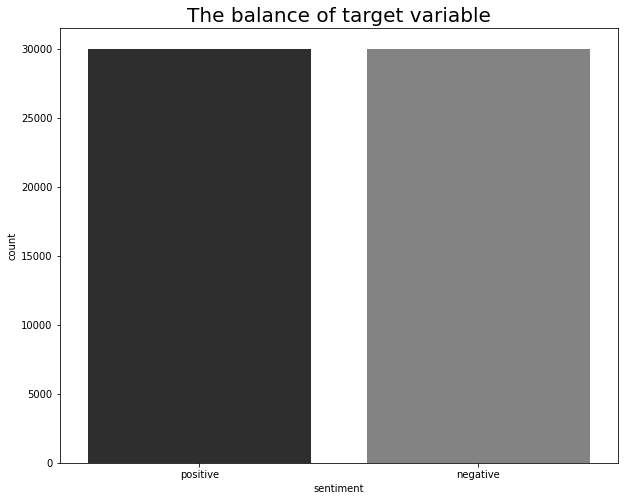

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x=df['sentiment'],palette=['#2e2e2e',"#838383"])
plt.title("The balance of target variable",fontsize=20)
from google.colab import files

plt.savefig("abc.png",transparent=True)
files.download("abc.png") 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [ ]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


In [ ]:
def clean_sentences(line):
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
        
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line
    

In [ ]:
df['review'] = df.review.apply(lambda s: clean_sentences(s))



In [ ]:
!pip install contractions

     |████████████████████████████████| 321 kB 39.3 MB/s 
     |████████████████████████████████| 284 kB 47.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85453 sha256=5f4b236a02fa8e9802eb71eb26c0c5ab9fe3a889d0a545806956c610665279f2
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import contractions

contractions_dict = contractions.contractions_dict
contractions_dict


{"'cause": 'because',
 "'tis": 'it is',
 "'twas": 'it was',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’m': 'I am',
 'I’m’a': 'I am about to',
 'I’m’o': 'I am going to',
 'I’ve': 'I have',
 'Whatcha': 'What are you',
 "ain't": 'are not',
 'ain’t': 'are not',
 "amn't": 'am not',
 'amn’t': 'am not',
 'apr.': 'april',
 "aren't": 'are not',
 'aren’t': 'are not',
 'aug.': 'august',
 "can't": 'cannot',
 "can't've": 'cannot have',
 'can’t': 'cannot',
 'can’t’ve': 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'could’ve': 'could have',
 "daren't": 'dare not',
 'daren’t': 'dare not',
 "daresn't": 'dare not',
 'daresn’t': 'dare not',
 "dasn't": 'dare no

In [ ]:
def contraction_expansion(x):
    
    if type(x) is str:
        
        for key in contractions_dict:
            
            value = contractions_dict[key]
            
            x = x.replace(key, value)
            
        return x
    
    else:
        
        return x

In [ ]:
df['review'] = df.review.apply(lambda s: contraction_expansion(s))



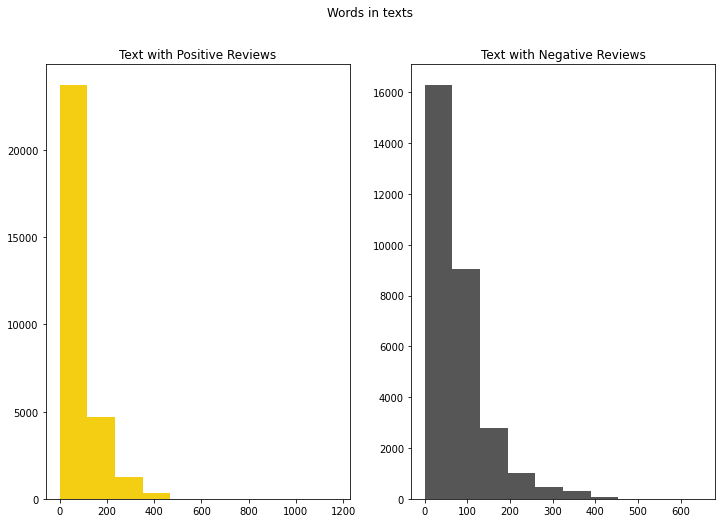

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='#f3ce13')
ax1.set_title('Text with Positive Reviews')


text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='#565656')
ax2.set_title('Text with Negative Reviews')
fig.suptitle('Words in texts')
from google.colab import files
plt.show()
plt.savefig('demo.png', transparent=True)
files.download("demo.png")

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'even': 26161,
 'film': 58805,
 'get': 19118,
 'good': 26191,
 'like': 41281,
 'movie': 69564,
 'one': 49781,
 'really': 24109,
 'see': 23102,
 'would': 26320}

<BarContainer object of 10 artists>

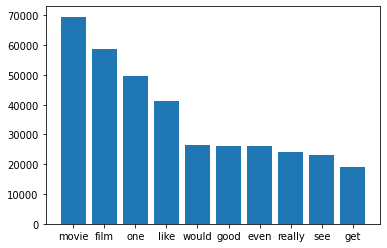

In [ ]:
plt.bar(*zip(*most_common.items()))


In [ ]:
df

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1
...,...,...
5830,writers say took finale breaking bad inspirati...,0
5831,message rushed point many arcs point gods lege...,0
5832,cant believe girlfriend told girlfriend,0
5833,one disappointment going waste time long hopef...,0


# Split data

In [ ]:

X = df['review']
y = df['sentiment']
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf=TfidfVectorizer(ngram_range=(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

tfidf=TfidfVectorizer(ngram_range=(1,1))
X_train=tfidf.fit_transform(X_train)
X_val=tfidf.transform(X_val)
X_test=tfidf.transform(X_test)


In [ ]:
X_train.shape, X_test.shape,X_val.shape

((36000, 70070), (12000, 70070), (12000, 70070))

In [ ]:
type(X_train)

scipy.sparse.csr.csr_matrix

# Logistic baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
y_pred  = lr_model.predict(X_test)

accuracy_train_set = lr_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = lr_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = lr_model.score(X_test, y_test)  #get accuracy on test set


print("Logistic Regression Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression Model, Accuracy (Val Set) : ", accuracy_valid_set)
print("Logistic Regression Model, Accuracy (test Set) : ", accuracy_test_set)




Logistic Regression Model, Accuracy (Train Set) :  0.9229444444444445
Logistic Regression Model, Accuracy (Val Set) :  0.8755
Logistic Regression Model, Accuracy (test Set) :  0.8815833333333334


In [ ]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred)
auc

0.881586551582614

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['Negatice Reviews','Positive Reviews']))


                  precision    recall  f1-score   support

Negatice Reviews       0.88      0.88      0.88      5985
Positive Reviews       0.88      0.88      0.88      6015

        accuracy                           0.88     12000
       macro avg       0.88      0.88      0.88     12000
    weighted avg       0.88      0.88      0.88     12000



Text(69.0, 0.5, 'Actual')

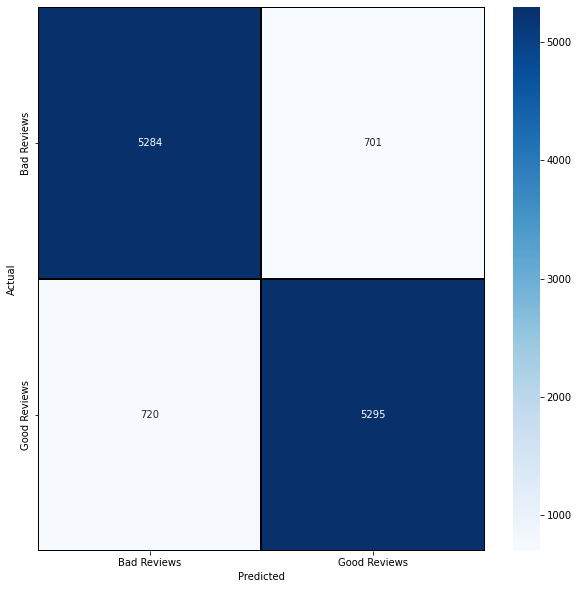

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x720 with 0 Axes>

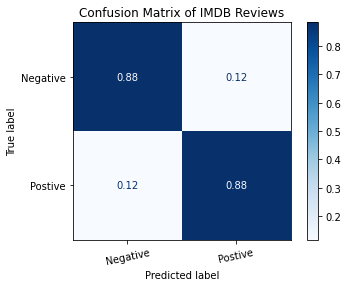

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix = confusion_matrix(y_pred,y_test, normalize='pred')
# Generate confusion matrix plot
display_labels = ['Negative', 'Postive']
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=display_labels)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.grid(False)
disp.ax_.set_xticklabels(display_labels, rotation=12)
plt.title('Confusion Matrix of IMDB Reviews')
plt.savefig("abc.png",transparent=True)
files.download("abc.png") 

In [ ]:
y_test.value_counts()

1    6015
0    5985
Name: sentiment, dtype: int64

In [ ]:
zz = lr_model.predict(tfidf.transform([
    "this is bad  "
]))

zz

array([0])

In [ ]:
if zz[0]==0:
  print('ddd')

ddd


# RandomForest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred  = rf_model.predict(X_test)

accuracy_train_set = rf_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = rf_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = rf_model.score(X_test, y_test)  #get accuracy on test set


print("RandomForest Model, Accuracy (Train Set) : ", accuracy_train_set)
print("RandomForest Model, Accuracy (Val Set) : ", accuracy_valid_set)
print("RandomForest Model, Accuracy (test Set) : ", accuracy_test_set)



RandomForest Model, Accuracy (Train Set) :  0.9999166666666667
RandomForest Model, Accuracy (Val Set) :  0.84225
RandomForest Model, Accuracy (test Set) :  0.8495


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['Negatice Reviews','Positive Reviews']))


                  precision    recall  f1-score   support

Negatice Reviews       0.85      0.85      0.85      5985
Positive Reviews       0.85      0.84      0.85      6015

        accuracy                           0.85     12000
       macro avg       0.85      0.85      0.85     12000
    weighted avg       0.85      0.85      0.85     12000



Text(69.0, 0.5, 'Actual')

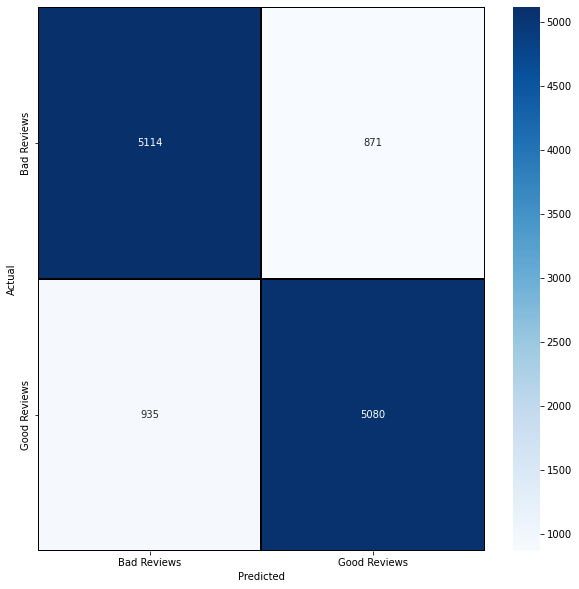

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# xGBOOST

In [ ]:
from xgboost import XGBClassifier
xg_model=XGBClassifier(verbosity=0)
xg_model.fit(X_train,y_train)
y_pred  = xg_model.predict(X_test)

accuracy_train_set = xg_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = xg_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = xg_model.score(X_test, y_test)  #get accuracy on test set


print("xgboost Model, Accuracy (Train Set) : ", accuracy_train_set)
print("xgboost Model, Accuracy (Val Set) : ", accuracy_valid_set)
print("xgboost Model, Accuracy (test Set) : ", accuracy_test_set)



xgboost Model, Accuracy (Train Set) :  0.8002777777777778
xgboost Model, Accuracy (Val Set) :  0.7819166666666667
xgboost Model, Accuracy (test Set) :  0.7894166666666667


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['Negatice Reviews','Positive Reviews']))


                  precision    recall  f1-score   support

Negatice Reviews       0.81      0.75      0.78      5985
Positive Reviews       0.77      0.83      0.80      6015

        accuracy                           0.79     12000
       macro avg       0.79      0.79      0.79     12000
    weighted avg       0.79      0.79      0.79     12000



Text(69.0, 0.5, 'Actual')

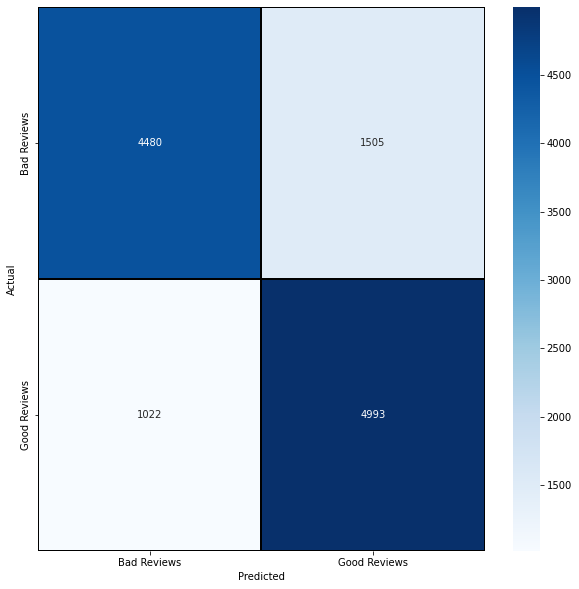

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# BaggingClassifier

In [ ]:

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
l2_norm = 8 #the square root of the sum of the squared vector values
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
 
bc_model = BaggingClassifier(base_estimator=LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations),
                            n_estimators=30, 
            random_state=0,  )

bc_model.fit(X_train,  y_train)
y_pred = bc_model.predict(X_test)
accuracy_train_set = bc_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = bc_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = bc_model.score(X_test, y_test)  #get accuracy on test set

print("Bagging Classifier, Accuracy (Train Set) : ", accuracy_train_set)
print("Bagging Classifier, Accuracy (val Set) : ", accuracy_valid_set)
print("Bagging Classifier, Accuracy (test Set) : ", accuracy_test_set)




Bagging Classifier, Accuracy (Train Set) :  0.9279444444444445
Bagging Classifier, Accuracy (val Set) :  0.8768333333333334
Bagging Classifier, Accuracy (test Set) :  0.8843333333333333


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['Negatice Reviews','Positive Reviews']))


                  precision    recall  f1-score   support

Negatice Reviews       0.88      0.89      0.88      5985
Positive Reviews       0.89      0.88      0.88      6015

        accuracy                           0.88     12000
       macro avg       0.88      0.88      0.88     12000
    weighted avg       0.88      0.88      0.88     12000



Text(69.0, 0.5, 'Actual')

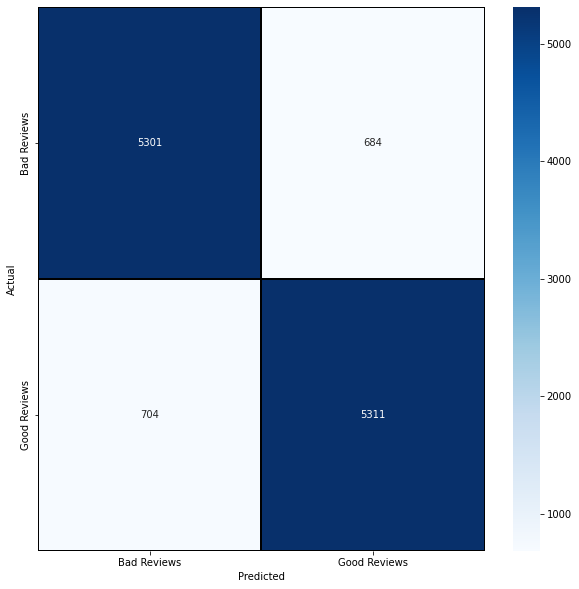

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# DecisionTreeClassifier

In [ ]:

from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)

dt_model.fit(X_train,  y_train)
y_pred = dt_model.predict(X_test)
accuracy_train_set = dt_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = dt_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = dt_model.score(X_test, y_test)  #get accuracy on test set

print("DecisionTreeClassifier, Accuracy (Train Set) : ", accuracy_train_set)
print("DecisionTreeClassifier, Accuracy (val Set) : ", accuracy_valid_set)
print("DecisionTreeClassifier, Accuracy (test Set) : ", accuracy_test_set)




DecisionTreeClassifier, Accuracy (Train Set) :  0.9999444444444444
DecisionTreeClassifier, Accuracy (val Set) :  0.7099166666666666
DecisionTreeClassifier, Accuracy (test Set) :  0.7098333333333333


# NAIVE BASE

In [ ]:
X = df['review']
y = df['sentiment']

In [ ]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert a collection of text documents to a matrix of token counts
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                              
                                   max_df = 0.6)

X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)
X_val = count_vectorizer.transform(X_val)

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
nb_model = MultinomialNB(alpha = 0.7,)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
accuracy_train_set = nb_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = nb_model.score(X_val, y_val)  #get accuracy on valid set
accuracy_test_set = nb_model.score(X_test, y_test)  #get accuracy on test set

print("MultinomialNB, Accuracy (Train Set) : ", accuracy_train_set)
print("MultinomialNB, Accuracy (val Set) : ", accuracy_valid_set)
print("MultinomialNB, Accuracy (test Set) : ", accuracy_test_set)





MultinomialNB, Accuracy (Train Set) :  0.9962777777777778
MultinomialNB, Accuracy (val Set) :  0.87275
MultinomialNB, Accuracy (test Set) :  0.87475


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['Negatice Reviews','Positive Reviews']))


                  precision    recall  f1-score   support

Negatice Reviews       0.87      0.88      0.88      5985
Positive Reviews       0.88      0.87      0.87      6015

        accuracy                           0.87     12000
       macro avg       0.87      0.87      0.87     12000
    weighted avg       0.87      0.87      0.87     12000



Text(69.0, 0.5, 'Actual')

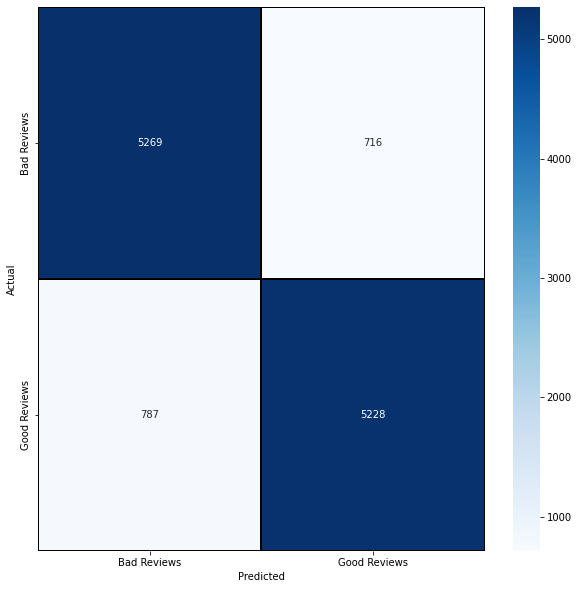

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Summary of models

In [ ]:
models_list = [lr_model,
               rf_model,
               xg_model,
               bc_model,
               dt_model,
               nb_model
               ]

In [ ]:

X = df['review']
y = df['sentiment']
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf=TfidfVectorizer(ngram_range=(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

tfidf=TfidfVectorizer(ngram_range=(1,1))
X_train=tfidf.fit_transform(X_train)
X_val=tfidf.transform(X_val)
X_test=tfidf.transform(X_test)


In [ ]:
models = []
accuracies = []
precisions = []
recalls = []
roc_scores = []
f1_scores = []
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
for model in models_list:
    
    if(model == models_list[-1]):
        count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                
                                      max_df = 0.6)
        X = df['review']
        y = df['sentiment']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
        X_train = count_vectorizer.fit_transform(X_train)
        X_test = count_vectorizer.transform(X_test)
        X_val = count_vectorizer.transform(X_val)

    accuracy = model.score(X_test, y_test)  #get accuracy
    y_pred = model.predict(X_test) #get predictions
    model_name = type(model).__name__
    print("Accuracy("+ model_name + "): ", accuracy.round(4)) #display accuracy
    print("F1 score("+ model_name + "): ", f1_score(y_test,y_pred).round(4)) #display F1
    print("Precision("+ model_name + "): ", precision_score(y_test,y_pred).round(4)) #display precision
    print("Recall("+ model_name + "): ",recall_score(y_test,y_pred).round(4)) #display recall
    print("ROC Score("+ model_name + "): ",roc_auc_score(y_test,y_pred).round(4)) #display recall
    
    print("\n")
    models.append(model_name)
    accuracies.append(accuracy.round(4))
    f1_scores.append(f1_score(y_test,y_pred).round(4))
    precisions.append(precision_score(y_test,y_pred).round(4))
    recalls.append(recall_score(y_test,y_pred).round(4))
    roc_scores.append(roc_auc_score(y_test,y_pred).round(4))


Accuracy(LogisticRegression):  0.8816
F1 score(LogisticRegression):  0.8817
Precision(LogisticRegression):  0.8831
Recall(LogisticRegression):  0.8803
ROC Score(LogisticRegression):  0.8816


Accuracy(RandomForestClassifier):  0.8495
F1 score(RandomForestClassifier):  0.8491
Precision(RandomForestClassifier):  0.8536
Recall(RandomForestClassifier):  0.8446
ROC Score(RandomForestClassifier):  0.8495


Accuracy(XGBClassifier):  0.7894
F1 score(XGBClassifier):  0.7981
Precision(XGBClassifier):  0.7684
Recall(XGBClassifier):  0.8301
ROC Score(XGBClassifier):  0.7893


Accuracy(BaggingClassifier):  0.8843
F1 score(BaggingClassifier):  0.8844
Precision(BaggingClassifier):  0.8859
Recall(BaggingClassifier):  0.883
ROC Score(BaggingClassifier):  0.8843


Accuracy(DecisionTreeClassifier):  0.7098
F1 score(DecisionTreeClassifier):  0.7074
Precision(DecisionTreeClassifier):  0.7151
Recall(DecisionTreeClassifier):  0.6999
ROC Score(DecisionTreeClassifier):  0.7099


Accuracy(MultinomialNB):  0.874

In [ ]:
results = pd.DataFrame({"Model" : models, "Accuracy" : accuracies,"F1" : f1_scores, "Precision" : precisions, "Recall" : recalls, 'ROC Score' :roc_scores})
results

,Model,Accuracy,F1,Precision,Recall,ROC Score
0,LogisticRegression,0.8816,0.8817,0.8831,0.8803,0.8816
1,RandomForestClassifier,0.8495,0.8491,0.8536,0.8446,0.8495
2,XGBClassifier,0.7894,0.7981,0.7684,0.8301,0.7893
3,BaggingClassifier,0.8843,0.8844,0.8859,0.8830,0.8843
4,DecisionTreeClassifier,0.7098,0.7074,0.7151,0.6999,0.7099
5,MultinomialNB,0.8748,0.8743,0.8795,0.8692,0.8748


In [ ]:
results.set_index('Model', inplace=True)
results

,Accuracy,F1,Precision,Recall,ROC Score
Model,,,,,
LogisticRegression,0.8816,0.8817,0.8831,0.8803,0.8816
RandomForestClassifier,0.8495,0.8491,0.8536,0.8446,0.8495
XGBClassifier,0.7894,0.7981,0.7684,0.8301,0.7893
BaggingClassifier,0.8843,0.8844,0.8859,0.8830,0.8843
DecisionTreeClassifier,0.7098,0.7074,0.7151,0.6999,0.7099
MultinomialNB,0.8748,0.8743,0.8795,0.8692,0.8748


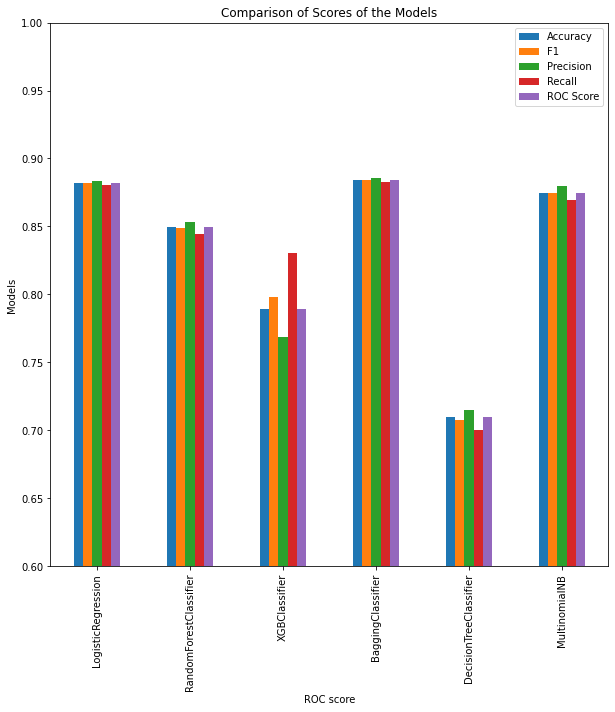

In [ ]:
results.plot(kind = 'bar',figsize=(10,10))
plt.title("Comparison of Scores of the Models")
plt.ylabel("Models")
plt.ylim(0.60, 1.0)
plt.xlabel("ROC score")
plt.show();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

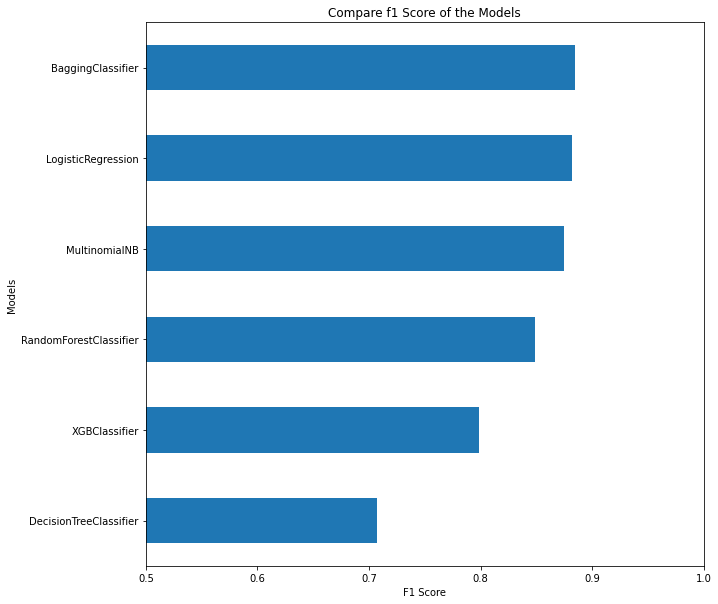

In [ ]:
plt.figure(figsize = (10,10))
x = results
x=x.sort_values(by=['F1'])

x["F1"].plot(kind = 'barh')
plt.title("Compare f1 Score of the Models")
plt.ylabel("Models")
plt.xlim(0.50, 1.0)
plt.xlabel("F1 Score")
plt.savefig("abc.png",transparent=True)

files.download("abc.png") 

# FLASK APP

In [ ]:
!pip install flask-ngrok


In [ ]:
import pandas as pd

import os


template_dir = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/pickles/templates')
static_folder = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/pickles/static')

from flask import Flask,request,render_template
from flask_ngrok import run_with_ngrok


app = Flask(__name__,template_folder=template_dir,static_folder =static_folder )
run_with_ngrok(app)   
@app.route('/',methods =['GET','POST'])
@app.route("/")
  
def home():
  if request.method == 'POST':
      usr_input = str(request.form.get('usr'))
      usr_input = denoise_text(usr_input)
      usr_input = clean_sentences(usr_input)
      usr_input = contraction_expansion(usr_input)
      print(usr_input)



      prd = bc_model.predict(tfidf.transform([usr_input]))

      if(prd[0] == 1 ):
        x = "Positive"
      else:
        x = "Negative"
      return render_template('styled_UI.html',val=x)

  return render_template('styled_UI.html')
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://989c-35-199-60-63.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [10/Oct/2021 12:14:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Oct/2021 12:14:14] "GET /static/styles.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Oct/2021 12:14:14] "GET /static/featured_imdb_tv-1.jpeg HTTP/1.1" 200 -
127.0.0.1 - - [10/Oct/2021 12:14:14] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [10/Oct/2021 12:14:31] "POST / HTTP/1.1" 200 -


great movie


127.0.0.1 - - [10/Oct/2021 12:22:39] "POST / HTTP/1.1" 200 -


great movie
